In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0


     |████████████████████████████████| 332.1MB 49kB/s 
     |████████████████████████████████| 61kB 27.1MB/s 
     |████████████████████████████████| 3.0MB 52.2MB/s 
     |████████████████████████████████| 419kB 57.0MB/s 


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [0]:
annotation_zip = tf.keras.utils.get_file('caption.zip' , 
                                        cache_subdir = os.path.abspath('.'),
                                        origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                        extract = True)

annotation_file = os.path.dirname(annotation_zip) + '/annotations/captions_train2014.json'

name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
  image_zip = tf.keras.utils.get_file(name_of_zip,
                                     cache_subdir = os.path.abspath('.'),
                                     origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                     extract = True)
  
  PATH = os.path.dirname(image_zip) + '/train2014/'

else:
  PATH = os.path.abspath('.') + '/train2014/'

13510574080/13510573713 [==============================] - 373s 0us/step


In [0]:
with open(annotation_file , 'r') as f:
  annotations = json.load(f)
 
print('annotations read.')
  
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
  caption = '<start> ' + annot['caption'] + ' <end>'
  image_id = annot['image_id']
  full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)
  
  all_img_name_vector.append(full_coco_image_path)
  all_captions.append(caption)
  
train_captions , img_name_vector = shuffle(all_captions , 
                                            all_img_name_vector , 
                                            random_state = 1)

print('shuffled.')
  
num_examples = 200000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]



print(len(train_captions) , len(all_captions))


annotations read.
shuffled.
200000 414113


In [0]:
np.save('train_captions.npy' , train_captions)

In [0]:
ls /content/train2014/


COCO_train2014_000000000009.jpg      COCO_train2014_000000291780.jpg.npy
COCO_train2014_000000000009.jpg.npy  COCO_train2014_000000291786.jpg
COCO_train2014_000000000025.jpg      COCO_train2014_000000291786.jpg.npy
COCO_train2014_000000000025.jpg.npy  COCO_train2014_000000291788.jpg
COCO_train2014_000000000030.jpg      COCO_train2014_000000291788.jpg.npy
COCO_train2014_000000000030.jpg.npy  COCO_train2014_000000291797.jpg
COCO_train2014_000000000034.jpg      COCO_train2014_000000291797.jpg.npy
COCO_train2014_000000000034.jpg.npy  COCO_train2014_000000291822.jpg
COCO_train2014_000000000036.jpg      COCO_train2014_000000291822.jpg.npy
COCO_train2014_000000000036.jpg.npy  COCO_train2014_000000291825.jpg
COCO_train2014_000000000049.jpg      COCO_train2014_000000291825.jpg.npy
COCO_train2014_000000000049.jpg.npy  COCO_train2014_000000291827.jpg
COCO_train2014_000000000061.jpg      COCO_train2014_000000291827.jpg.npy
COCO_train2014_000000000061.jpg.npy  COCO_train2014_000000291839.jpg
COCO_t

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img , channels = 3)
  img = tf.image.resize(img , (299 , 299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img , image_path
  

In [0]:
image_model = tf.keras.applications.InceptionV3(include_top = False ,
                                               weights = 'imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input , hidden_layer)

87916544/87910968 [==============================] - 3s 0us/step


In [0]:
!pip install -q tqdm

In [0]:
from tqdm import tqdm

In [0]:
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image , num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(16)

for img , path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features.shape
  batch_features = tf.reshape(batch_features , (batch_features.shape[0] , -1 , batch_features.shape[3]))
  
  for bf , p in zip(batch_features , path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature , bf.numpy())
  

4980it [16:22,  2.64it/s]


In [0]:
def calc_max_length(tensor):
  return max(len(t) for t in tensor)

In [0]:
top_k = 6000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = top_k,
                                                 oov_token = "<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [0]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs , padding = 'post')


In [0]:
max_length = calc_max_length(train_seqs)
max_length

51

In [0]:
img_name_train , img_name_val , cap_train , cap_val = train_test_split(img_name_vector , cap_vector , test_size = 0.2 , random_state = 0)

In [0]:
print(len(img_name_train), len(cap_train), len(img_name_val), len(cap_val))

160000 160000 40000 40000


In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train)//BATCH_SIZE

features_shape = 2048
attention_features_shape = 64

In [0]:
vocab_size

17990

In [0]:
def map_func(img_name , cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor , cap

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train , cap_train))

dataset = dataset.map(lambda item1 , item2: tf.numpy_function(
                      map_func , [item1 , item2] , [tf.float32 , tf.int32]),
                      num_parallel_calls = tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

W0607 02:08:31.566200 140527781357440 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/script_ops.py:476: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [0]:
class Attention(tf.keras.Model):
  def __init__(self , units):
    super(Attention , self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
    
  def call(self , features , hidden):
    hidden_with_time_axis = tf.expand_dims(hidden , 1)

    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    attention_weights = tf.nn.softmax(self.V(score) , axis = 1)

    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector , axis = 1)

    return context_vector , attention_weights

In [0]:
class CNN_Encoder(tf.keras.Model):
  def __init__(self , embedding_dim):
    super(CNN_Encoder , self).__init__()
    self.fc = tf.keras.layers.Dense(embedding_dim)
    
  def call(self , x):
    x = self.fc(x)
    x = tf.nn.relu(x)
    return x

In [0]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self , embedding_dim , units , vocab_size):
    super(RNN_Decoder , self).__init__()
    self.units = units
    self.embedding = tf.keras.layers.Embedding(vocab_size , embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units , return_sequences = True , return_state = True , recurrent_initializer = 'glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    self.attention = Attention(self.units)
    
  def call(self , x , features , hidden):
    context_vector , attention_weights = self.attention(features , hidden)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector , 1) , x] , axis = -1)
    output , state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x , (-1 , x.shape[2]))
    x = self.fc2(x)

    return x , state , attention_weights

  def reset_state(self , batch_size):
    return tf.zeros((batch_size , self.units))

In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim , units , vocab_size)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True , reduction = 'none')

def loss_function(real , pred):
  mask = tf.math.logical_not(tf.math.equal(real , 0))
  loss_ = loss_object(real , pred)
  
  mask = tf.cast(mask , dtype = loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

In [0]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder = encoder,
                          decoder = decoder,
                          optimizer = optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt , checkpoint_path , max_to_keep = 5)

In [0]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [0]:
loss_plot = []

In [0]:
@tf.function
def train_step(img_tensor , target):
  loss = 0
  
  hidden = decoder.reset_state(batch_size = target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE , 1)
  
  with tf.GradientTape() as tape:
    features = encoder(img_tensor)
    
    for i in range(1 , target.shape[1]):
      predictions , hidden , _ = decoder(dec_input , features , hidden)
      
      loss += loss_function(target[:, i] , predictions)
      
      dec_input = tf.expand_dims(target[:, i] , 1)
    
  
  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss , trainable_variables)
  optimizer.apply_gradients(zip(gradients , trainable_variables))
  return loss , total_loss

In [0]:
EPOCHS = 20

for epoch in range(start_epoch , EPOCHS):
  start = time.time()
  total_loss = 0
  
  for (batch , (img_tensor , target)) in enumerate(dataset):
    batch_loss , t_loss = train_step(img_tensor , target)
    total_loss += t_loss
    
    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1 , batch , batch_loss.numpy() / int(target.shape[1])))
      
  loss_plot.append(total_loss / num_steps)
  
  if epoch % 5 == 0:
    ckpt_manager.save()
    
  print('Epoch {} Loss {:.6f}'.format(epoch + 1 , total_loss/num_steps))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    

Epoch 1 Batch 0 Loss 2.2042
Epoch 1 Batch 100 Loss 1.1554
Epoch 1 Batch 200 Loss 0.9828
Epoch 1 Batch 300 Loss 0.8549
Epoch 1 Batch 400 Loss 0.9299
Epoch 1 Batch 500 Loss 0.8289
Epoch 1 Batch 600 Loss 0.7746
Epoch 1 Batch 700 Loss 0.8020
Epoch 1 Batch 800 Loss 0.7873
Epoch 1 Batch 900 Loss 0.7084
Epoch 1 Batch 1000 Loss 0.7451
Epoch 1 Batch 1100 Loss 0.7823
Epoch 1 Batch 1200 Loss 0.6818
Epoch 1 Batch 1300 Loss 0.6846
Epoch 1 Batch 1400 Loss 0.7498
Epoch 1 Batch 1500 Loss 0.7206
Epoch 1 Batch 1600 Loss 0.6917
Epoch 1 Batch 1700 Loss 0.7408
Epoch 1 Batch 1800 Loss 0.6858
Epoch 1 Batch 1900 Loss 0.7082
Epoch 1 Batch 2000 Loss 0.6831
Epoch 1 Batch 2100 Loss 0.7406
Epoch 1 Batch 2200 Loss 0.6479
Epoch 1 Batch 2300 Loss 0.6964
Epoch 1 Batch 2400 Loss 0.6412
Epoch 1 Loss 0.778036
Time taken for 1 epoch 979.1329808235168 sec

Epoch 2 Batch 0 Loss 0.6962
Epoch 2 Batch 100 Loss 0.6712
Epoch 2 Batch 200 Loss 0.6023
Epoch 2 Batch 300 Loss 0.5704
Epoch 2 Batch 400 Loss 0.7197
Epoch 2 Batch 500 Los

In [0]:
!ls checkpoints/train
!chmod 600 'checkpoints/'

checkpoint		    ckpt-3.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-3.index
ckpt-1.index		    ckpt-4.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-4.index
ckpt-2.index


In [0]:
from google.colab import files


In [0]:
!zip -r '/content/checkpoint.zip' '/content/checkpoints'

  adding: content/checkpoints/ (stored 0%)
  adding: content/checkpoints/train/ (stored 0%)
  adding: content/checkpoints/train/checkpoint (deflated 67%)
  adding: content/checkpoints/train/ckpt-1.data-00000-of-00001 (deflated 23%)
  adding: content/checkpoints/train/ckpt-2.data-00000-of-00001 (deflated 23%)
  adding: content/checkpoints/train/ckpt-1.index (deflated 68%)
  adding: content/checkpoints/train/ckpt-4.data-00000-of-00001 (deflated 24%)
  adding: content/checkpoints/train/ckpt-2.index (deflated 68%)
  adding: content/checkpoints/train/ckpt-4.index (deflated 68%)
  adding: content/checkpoints/train/ckpt-3.index (deflated 68%)
  adding: content/checkpoints/train/ckpt-3.data-00000-of-00001 (deflated 24%)


In [0]:
train_captions

['<start> A skateboarder performing a trick on a skateboard ramp. <end>',
 '<start> a person soaring through the air on skis <end>',
 '<start> a wood door with some boards laid against it <end>',
 '<start> A Do Not Enter sign is posted along a road leading to a stadium. <end>',
 '<start> Small child in a high chair eating off of a green plate.  <end>',
 '<start> groups of people standing around the toilet area <end>',
 '<start> a hand is holding a black and silver cellphone <end>',
 '<start> People working on laptop computers in a student dining room <end>',
 '<start> two birds near one another in a field  <end>',
 '<start> A man talking on a cell phone in a park. <end>',
 '<start> A group of men standing around a table with microphones while one makes a speech. <end>',
 '<start> A bathroom with a toilet and sprayer attached to the wall. <end>',
 '<start> A woman sitting on a wooden bench talking on a phone. <end>',
 '<start> A woman with a clock on her purse at the market. <end>',
 '<

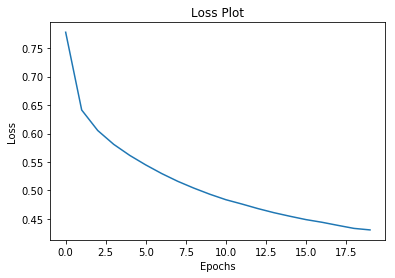

In [0]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [0]:
def evaluate(image):
  attention_plot = np.zeros((max_length , attention_features_shape))
  
  hidden = decoder.reset_state(batch_size = 1)
  
  temp_input = tf.expand_dims(load_image(image)[0] , 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val , (img_tensor_val.shape[0] , -1 , img_tensor_val.shape[3]))
  
  features = encoder(img_tensor_val)
  
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] , 0)
  result = []
  
  for i in range(max_length):
    predictions , hidden , attention_weights = decoder(dec_input , features , hidden)
    
    attention_plot[i] = tf.reshape(attention_weights , (-1, )).numpy()
    
    predicted_id = tf.argmax(predictions[0]).numpy()
    result.append(tokenizer.index_word[predicted_id])
    
    if tokenizer.index_word[predicted_id] == '<end>' :
      return result , attention_plot
    
    dec_input = tf.expand_dims([predicted_id] , 0)
    
  attention_plot = attention_plot[:len(result) , :]
  
  return result , attention_plot

Prediction Caption: a man is sitting on a couch with a phone <end>


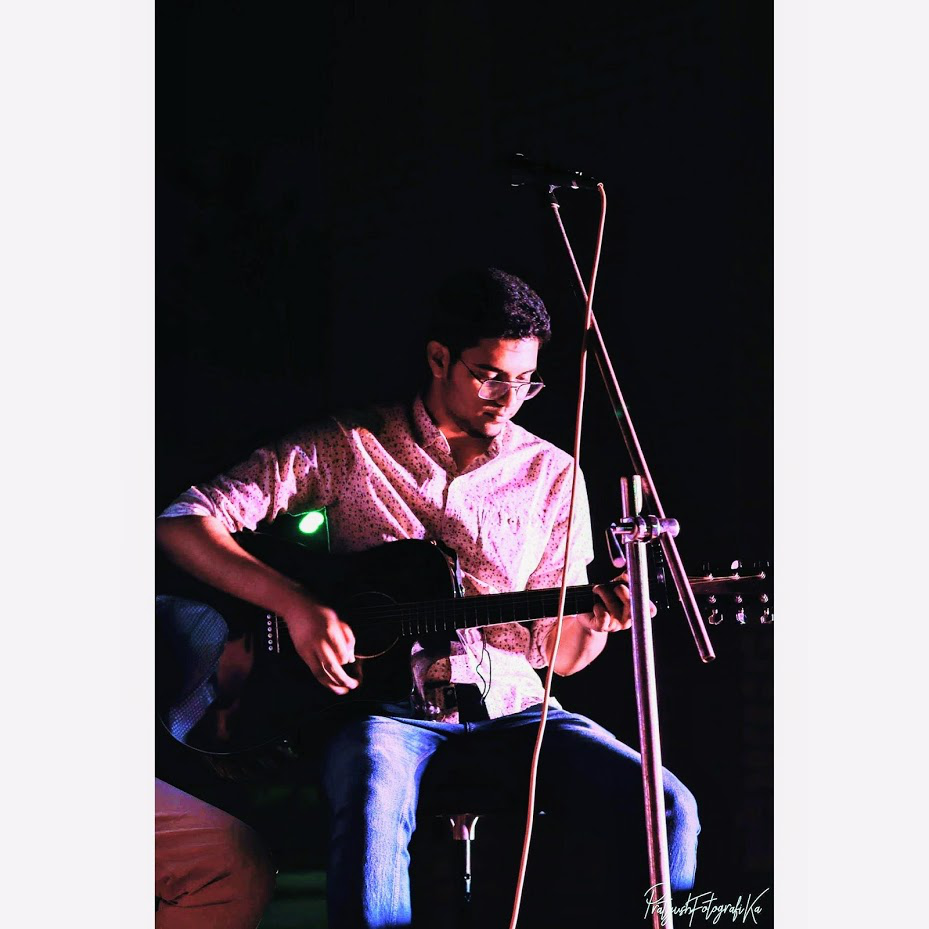

In [0]:

image_path = 'IMG_20181209_123912_673.jpg'

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
#plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [0]:
image_path

'/root/.keras/datasets/image.jpg'